In [295]:
# Importing necessary packages

import numpy as np 
import pandas as pd 
import json 
from geopy.geocoders import Nominatim 
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [32]:
# Loading necessary geo data in json format

with open('C:\\Users\\saich\\Desktop\\KSC Old\\Certification\\IBM Data Science\\boston-master\\boston-master\\data\\boston-neighborhoods.json') as json_data:
    boston_data = json.load(json_data)

In [ ]:
neighborhoods_data = boston_data['features']

In [146]:
# Building master dataset by extracting necessary features from json dataset
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# Extracting necessary data
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods_data = newyork_data['features']
for data in neighborhoods_data: 
    neighborhood_name = data['properties']['Name']
    neighborhood_latlon = data['geometry']['coordinates'][0][0][0]
    if type(neighborhood_latlon) == list:
        neighborhood_latlon = data['geometry']['coordinates'][0][0][0]
        neighborhood_lat = neighborhood_latlon[0]
        neighborhood_lon = neighborhood_latlon[1]
    elif type(neighborhood_latlon) == float:
        neighborhood_lat = data['geometry']['coordinates'][0][0][0]
        neighborhood_lon = data['geometry']['coordinates'][0][0][1]
    else: 
        print("Check code")
    
    neighborhoods = neighborhoods.append({"Neighborhood":neighborhood_name,"Latitude":neighborhood_lat,"Longitude": neighborhood_lon},ignore_index= True)  

In [148]:
# Obtaining necessary geo data for boston

address = 'Boston, MA'
geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 42.3602534, -71.0582912.


In [162]:
# Initializing map for Boston city
map_boston = folium.Map(location=[latitude, longitude], zoom_start=10)

# Adding neighborhood pointers to map
for lat, lng, neighborhood in zip(neighborhoods['Longitude'], neighborhoods['Latitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

In [163]:
# Below are the credentials required for obtaining necessary data from foursquare API\
CLIENT_ID = 'MHPVEPYUQ2KBD3OJTU2SF1JWFQ2NQKYDE1JLJ1DXZ3VVKXDV'
CLIENT_SECRET = '1FGACI0MBBDVVDQ1QBAEB1QYVSSXGYPOSKY2CU0ISSOIRGLW' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MHPVEPYUQ2KBD3OJTU2SF1JWFQ2NQKYDE1JLJ1DXZ3VVKXDV
CLIENT_SECRET:1FGACI0MBBDVVDQ1QBAEB1QYVSSXGYPOSKY2CU0ISSOIRGLW


In [186]:
# Associated details of the neighborhood

neighborhoods.loc[0, 'Neighborhood']
neighborhood_latitude = neighborhoods.loc[6, 'Longitude']
neighborhood_longitude = neighborhoods.loc[6, 'Latitude']
neighborhood_name = neighborhoods.loc[6, 'Neighborhood']

In [187]:
# Send requests using foursquare API by defining constraints such as limit and radius
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=MHPVEPYUQ2KBD3OJTU2SF1JWFQ2NQKYDE1JLJ1DXZ3VVKXDV&client_secret=1FGACI0MBBDVVDQ1QBAEB1QYVSSXGYPOSKY2CU0ISSOIRGLW&v=20180605&ll=42.35236995975563,-71.05790492479626&radius=500&limit=100'

In [188]:
# Obtain data stored in that url using requests function
results = requests.get(url).json()

In [190]:
# Write a function to extract categories of venues and names of the venues
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [191]:
# Pulling details such as lat and long values of the venue
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Tatte Bakery & Cafe,Bakery,42.353111,-71.057117
1,Clover Food Lab FIN,Vegetarian / Vegan Restaurant,42.353715,-71.056216
2,sweetgreen,Salad Place,42.353943,-71.058550
3,Gracenote Coffee,Coffee Shop,42.351657,-71.058204
4,O Ya,Sushi Restaurant,42.351502,-71.056763


In [197]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)    
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']   
    return(nearby_venues)

In [200]:
boston_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Longitude'],
                                   longitudes=neighborhoods['Latitude']
                                  )

Harbor Islands
completed


[2, 7, 20, 10, 2, 1, 37, 4, 2, 1, 5, 0, 5, 37, 2, 1, 7, 11, 0, 1, 12, 15, 22, 1, 0]


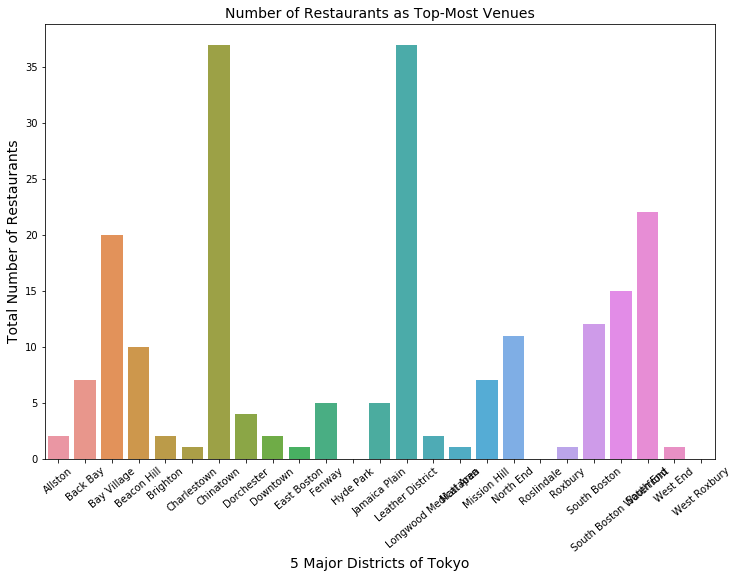

In [294]:
#try groupby to play with restaurant 
import matplotlib.pyplot as plt
import seaborn as sns
boston_venues_restaurant = boston_venues.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
boston_venues_restaurant_df = boston_venues_restaurant.to_frame().reset_index()
boston_venues_restaurant_df.columns = ['District', 'Number of Restaurant']
boston_venues_restaurant_df.index = np.arange(1, len(boston_venues_restaurant_df)+1)
list_rest_no = list(boston_venues_restaurant_df['Number of Restaurant'])
print (list_rest_no)
fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='District', y='Number of Restaurant', data=boston_venues_restaurant_df)
bar.set_ylabel("Total Number of Restaurants", fontsize=14)
bar.set_xlabel("5 Major Districts in Boston", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Number of Restaurants as Top-Most Venues", fontsize=14)
plt.show()

In [202]:
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

In [204]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,ATM,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Business Service,Cafeteria,Café,Caribbean Restaurant,Casino,Cemetery,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Quad,College Rec Center,Colombian Restaurant,Comedy Club,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,History Museum,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kids Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Polish Restaurant,Pub,Racetrack,Rental Car Location,Resort,Restaurant,River,Rock Climbing Spot,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taxi,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Track,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,Allston,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.058824,0.000000,0.00000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.117647,0.000000,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [205]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allston----
           venue  freq
0            Bar  0.12
1    Pizza Place  0.12
2    Coffee Shop  0.06
3  Metro Station  0.06
4           Park  0.06


----Back Bay----
                 venue  freq
0   Italian Restaurant  0.07
1                 Café  0.07
2          Pizza Place  0.07
3  American Restaurant  0.05
4       Clothing Store  0.05


----Bay Village----
                venue  freq
0              Bakery  0.05
1  Seafood Restaurant  0.05
2               Hotel  0.05
3             Theater  0.05
4          Steakhouse  0.04


----Beacon Hill----
                 venue  freq
0            Hotel Bar  0.11
1   Italian Restaurant  0.08
2  American Restaurant  0.05
3           Food Truck  0.05
4            Gift Shop  0.05


----Brighton----
           venue  freq
0            Bar  0.12
1    Pizza Place  0.12
2    Coffee Shop  0.06
3  Metro Station  0.06
4           Park  0.06


----Charlestown----
            venue  freq
0     Coffee Shop  0.11
1             Gym  0.06
2         Theate

In [207]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [208]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(i nd+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Bar,Pizza Place,Convenience Store,Pharmacy,Coffee Shop,Park,Chinese Restaurant,Speakeasy,Plaza,Gastropub
1,Back Bay,Italian Restaurant,Café,Pizza Place,Clothing Store,Gift Shop,American Restaurant,Cupcake Shop,Scenic Lookout,River,Restaurant
2,Bay Village,Theater,Hotel,Seafood Restaurant,Bakery,Sandwich Place,Steakhouse,Italian Restaurant,Performing Arts Venue,Chinese Restaurant,Spa
3,Beacon Hill,Hotel Bar,Italian Restaurant,Food Truck,Pizza Place,Gift Shop,American Restaurant,Bistro,Hotel,Restaurant,Pub
4,Brighton,Bar,Pizza Place,Convenience Store,Pharmacy,Coffee Shop,Park,Chinese Restaurant,Speakeasy,Plaza,Gastropub


In [251]:
# set number of clusters
kclusters = 7

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
clusters = kmeans.labels_

In [267]:
neighborhoods.drop(neighborhoods.tail(1).index,inplace=True)

In [269]:
# add clustering labels
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels',1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', clusters)

manhattan_merged = neighborhoods
manhattan_merged
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
manhattan_merged['Cluster Labels'] = manhattan_merged['Cluster Labels'].apply(np.int64)
manhattan_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Roslindale,-71.125927,42.272004,4,Baseball Field,Playground,Rock Climbing Spot,Liquor Store,Train Station,Park,Zoo Exhibit,Fast Food Restaurant,Farmers Market,Falafel Restaurant
1,Jamaica Plain,-71.104992,42.326093,6,Sandwich Place,Mobile Phone Shop,Latin American Restaurant,Caribbean Restaurant,Metro Station,Donut Shop,Paella Restaurant,Southern / Soul Food Restaurant,Convenience Store,Pizza Place
2,Mission Hill,-71.090434,42.335761,1,Café,Donut Shop,Sandwich Place,Bookstore,Grocery Store,Coffee Shop,Burger Joint,Fast Food Restaurant,Soccer Field,Mexican Restaurant
3,Longwood Medical Area,-71.098108,42.336722,1,Art Museum,Art Gallery,Café,Gastropub,Coffee Shop,Grocery Store,Gym,Gym / Fitness Center,Donut Shop,Food Truck
4,Bay Village,-71.066629,42.348774,1,Theater,Hotel,Seafood Restaurant,Bakery,Sandwich Place,Steakhouse,Italian Restaurant,Performing Arts Venue,Chinese Restaurant,Spa


In [284]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [285]:
latitude

42.3602534

In [286]:
# add markers to the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lon, poi, cluster in zip(manhattan_merged['Longitude'], manhattan_merged['Latitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(poi, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)    
    
map_clusters

In [287]:
manhattan_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Roslindale,-71.125927,42.272004,4,Baseball Field,Playground,Rock Climbing Spot,Liquor Store,Train Station,Park,Zoo Exhibit,Fast Food Restaurant,Farmers Market,Falafel Restaurant
1,Jamaica Plain,-71.104992,42.326093,6,Sandwich Place,Mobile Phone Shop,Latin American Restaurant,Caribbean Restaurant,Metro Station,Donut Shop,Paella Restaurant,Southern / Soul Food Restaurant,Convenience Store,Pizza Place
2,Mission Hill,-71.090434,42.335761,1,Café,Donut Shop,Sandwich Place,Bookstore,Grocery Store,Coffee Shop,Burger Joint,Fast Food Restaurant,Soccer Field,Mexican Restaurant
3,Longwood Medical Area,-71.098108,42.336722,1,Art Museum,Art Gallery,Café,Gastropub,Coffee Shop,Grocery Store,Gym,Gym / Fitness Center,Donut Shop,Food Truck
4,Bay Village,-71.066629,42.348774,1,Theater,Hotel,Seafood Restaurant,Bakery,Sandwich Place,Steakhouse,Italian Restaurant,Performing Arts Venue,Chinese Restaurant,Spa
5,Leather District,-71.058378,42.349822,1,Asian Restaurant,Chinese Restaurant,Bakery,Coffee Shop,Sandwich Place,Food Truck,Sushi Restaurant,Dessert Shop,Noodle House,Vietnamese Restaurant
6,Chinatown,-71.057905,42.352370,1,Coffee Shop,Chinese Restaurant,Asian Restaurant,Bakery,Sandwich Place,Sushi Restaurant,Gym,Italian Restaurant,Food Truck,Dim Sum Restaurant
7,North End,-71.051995,42.368827,5,Italian Restaurant,Harbor / Marina,Wine Shop,Park,Beer Garden,Pizza Place,Outdoor Sculpture,Church,Resort,Cemetery
8,Roxbury,-71.096459,42.293224,0,Dance Studio,Middle Eastern Restaurant,Bar,Zoo Exhibit,Electronics Store,Food Truck,Food Service,Fast Food Restaurant,Farmers Market,Falafel Restaurant
9,South End,-71.068340,42.347742,1,American Restaurant,Theater,Seafood Restaurant,Italian Restaurant,Hotel,Performing Arts Venue,Sandwich Place,Steakhouse,Bakery,Pizza Place
